# 10.9.1 Computer Exercise 10.1: FHSS FSK under Partial Band Jamming

<span style="color:red"> <b>* Note: Refer to the description from textbook Section 10.9 *</b></span>


In [3]:
import numpy as np
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
from scipy.signal import welch, get_window
from scipy.special import erfc

jamming=? (Enter 1 for Yes, 0 for No) 1


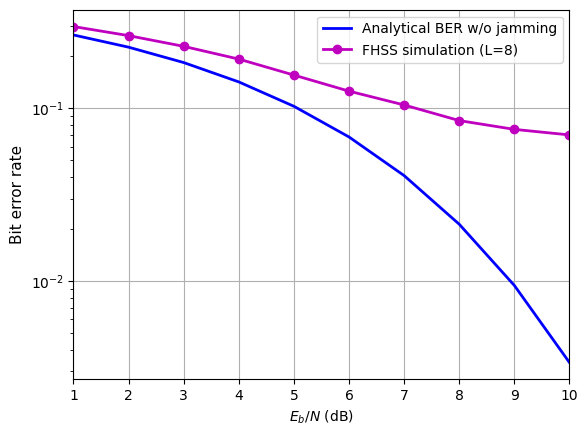

In [4]:
''' Save the following as ExFHSS.py
This program provides simulation for FHSS signaling using non-coherent detection
of FSK. The jammer will jam 1 of the L frequency bands and can be turned on or
off by inputting jamming=1 or 0 Non-coherent MFSK detection only needs to
compare the magnitude of each frequency bin.'''
n = 10000   # Number of data symbols in the simulation
L = 8       # Number of frequency bands
Lh = 1      # Number of hops per symbol (bit)
m = 1       # Number of users
s_data = np.round(np.random.rand(n, m))  # Generating information bits

# Turn partial band jamming on or off to test BER via keyboard
jamming = int(input('jamming=? (Enter 1 for Yes, 0 for No)'))

# Generating random phases on the two frequencies
xbase1 = np.exp(1j * 2 * np.pi * np.random.rand(Lh * n, 1))
xbase0 = np.exp(1j * 2 * np.pi * np.random.rand(Lh * n, 1))
# Modulating two orthogonal frequencies
xmodsig = np.concatenate([np.kron(s_data, np.ones((Lh, 1))) * xbase1,
                      np.kron(1 - s_data, np.ones((Lh, 1))) * xbase0], axis=1)
del xbase0, xbase1
# Generating a random hopping sequence n * Lh long
Phop = np.random.randint(0, L, Lh * n)
Xsiga =coo_matrix((xmodsig[:,0],(np.arange(Lh*n),Phop)),shape=(Lh*n,L)).toarray()
Xsigb =coo_matrix((xmodsig[:,1],(np.arange(Lh*n),Phop)),shape=(Lh*n,L)).toarray()
# Generating noise sequences for both frequency channels
noise1 = np.random.randn(Lh * n) + 1j * np.random.randn(Lh * n)
noise2 = np.random.randn(Lh * n) + 1j * np.random.randn(Lh * n)
Nsiga = coo_matrix((noise1, (np.arange(Lh*n), Phop)), shape=(Lh*n, L)).toarray()
Nsigb = coo_matrix((noise2, (np.arange(Lh*n), Phop)), shape=(Lh*n, L)).toarray()
del noise1, noise2, xmodsig

BER = []; BER_az = []; Eb2N = []   # building output arrays for plotting
# Add a jammed channel (randomly picked)
if jamming:
    nch = np.random.randint(0, L)
    Xsiga[:, nch] = 0;     Xsigb[:, nch] = 0
    Nsiga[:, nch] = 0;     Nsigb[:, nch] = 0
# Generating the channel noise (AWGN)
for i in range(10):
    Eb2N.append(i+1)  # (Eb/N in dB)
    Eb2N_num = 10**(Eb2N[i]/10)  # Eb/N in numeral
    Var_n = 1/(2*Eb2N_num)  # 1/SNR is the noise variance
    signois = np.sqrt(Var_n)  # standard deviation
    ych1 = Xsiga + signois * Nsiga  # AWGN complex channels
    ych2 = Xsigb + signois * Nsigb  # AWGN channels
# Non-coherent detection
    dec = np.zeros(n)
    for kk in range(n):
        Yvec1 = np.zeros(Lh,dtype=complex); Yvec2 = np.zeros(Lh,dtype=complex)
        for kk2 in range(Lh):
            Yvec1[kk2] = ych1[kk*Lh+kk2, Phop[kk*Lh+kk2]]
            Yvec2[kk2] = ych2[kk*Lh+kk2, Phop[kk*Lh+kk2]]
        ydim1 = Yvec1.dot(np.conjugate(Yvec1))
        ydim2 = Yvec2.dot(np.conjugate(Yvec2))
        dec[kk] = (ydim1 > ydim2)

    BER.append(np.sum(dec != s_data.flatten()) / n); #calculating BER
    BER_az.append(0.5*np.exp(-Eb2N_num/2));   # Compare against analytical BER
BER = np.array(BER)
BER[BER==0] = np.nan # replace 0 with 'nan' to avoid 0 when plotting in logscale
figber=plt.semilogy(Eb2N,BER_az,'b-',Eb2N,BER,'m-o',linewidth=2)
plt.legend(['Analytical BER w/o jamming', 'FHSS simulation (L=8)'])
fx=plt.xlabel(r'$E_b/N$ (dB)'); plt.grid()
fy=plt.ylabel('Bit error rate',fontsize=11)
plt.xlim(1,10);  plt.show()

<img src="images/Fig10_22.png" width="600" />

<center><b>Figure 10.22</b> Performance of FHSS noncoherent detection under partial band jamming. </center>

# 10.9.2 Computer Exercise 10.2: DSSS Transmission of QPSK
<span style="color:red"> <b>*Note: text from Section 10.9 skipped*</b></span>


Text(0, 0.5, 'CDMA signal + narrowband jammer PSD')

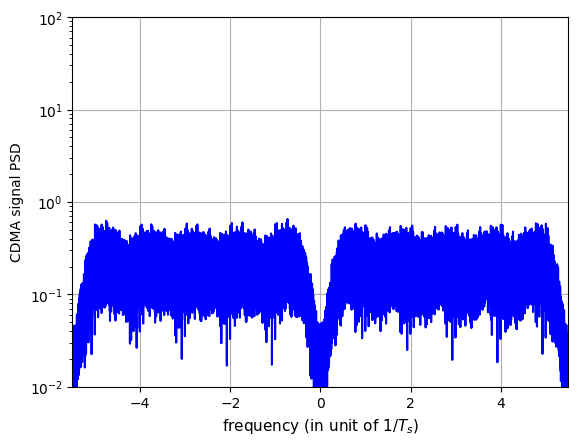

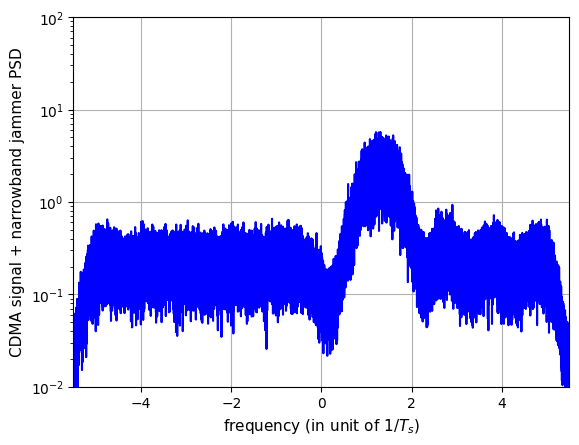

In [5]:
'''This ExDSSS.py provides simulation for DS-CDMA signaling using coherent QAM
detection. To illustrate the CDMA spreading effect, a single user is spread by
PN sequence of different lengths. Jamming is added as a narrowband;
Changing spreading gain Lc '''
Ldata = 20000  # data length in simulation; Must be divisible by 8
Lc = 11  # spreading factor vs data rate, can also use the shorter Lc=7

# Generate QPSK modulation symbols
data_sym = 2 * np.round(np.random.rand(Ldata, 1)) - 1 + \
            1j * (2 * np.round(np.random.rand(Ldata, 1)) - 1)
jam_data = 2 * np.round(np.random.rand(Ldata, 1)) - 1 + \
            1j * (2 * np.round(np.random.rand(Ldata, 1)) - 1)
# Generating a spreading code
pcode = np.array([1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1]).reshape((-1, 1))
# Now we spread signal
x_in = np.kron(data_sym, pcode).flatten()
# Signal power of the channel input is 2*Lc;
SIR = 10  # SIR in dB.  Change this value for different jamming strength
Pj = 2 * Lc / (10 ** (SIR / 10))    # Jamming power is relative
# Generate noise (AWGN) with power = 2
noiseq = np.random.randn(Ldata * Lc, 1) + 1j * np.random.randn(Ldata * Lc, 1)

# Add jamming sinusoid sampling frequency is fc = Lc
jam_mod = np.kron(jam_data, np.ones((Lc, 1))); del jam_data
jammer = np.sqrt(Pj / 2) * jam_mod * np.exp(1j * 2 * \
                    np.pi * 0.12 * np.arange(1, Ldata * Lc + 1).reshape(-1,1))
jammer = jammer.flatten();   del jam_mod
fs = 4096
the_hamming_window = get_window('hamming', np.floor(len(x_in)/4.5).astype(int))

# Same as MATLAB, default Length of the FFT (nfft) is the greater of 256 or
# the next power of 2 greater than the length of the segments.
nfft = max(256, 2**np.ceil(np.log2(len(the_hamming_window))))
x, P = welch(x_in,fs=1,window=the_hamming_window,nfft = nfft,
             scaling='density',return_onesided=False,detrend=False)
x = np.fft.fftshift(x)*Lc

fig1 = plt.figure(); fig1.subplots_adjust(hspace=0.5,wspace=0.4)
plt.semilogy(x, np.fft.fftshift(P)/Lc,'b')
plt.axis([-Lc/2, Lc/2, 1.e-2, 1.e2]); plt.grid()
plt.xlabel(r'frequency (in unit of $1/T_s$)',fontsize=11)
plt.ylabel('CDMA signal PSD')
x, P = welch(jammer+x_in,fs=1,window=the_hamming_window,
             nfft = nfft,scaling='density',return_onesided=False,detrend=False)
x = np.fft.fftshift(x)*Lc
fig2 = plt.figure(); fig2.subplots_adjust(hspace=0.5,wspace=0.4)
plt.semilogy(x, np.fft.fftshift(P)/Lc,'b'); plt.grid()
plt.axis([-Lc/2, Lc/2, 1.e-2, 1.e2])
plt.xlabel(r'frequency (in unit of $1/T_s$)',fontsize=11)
plt.ylabel('CDMA signal + narrowband jammer PSD',fontsize=11)

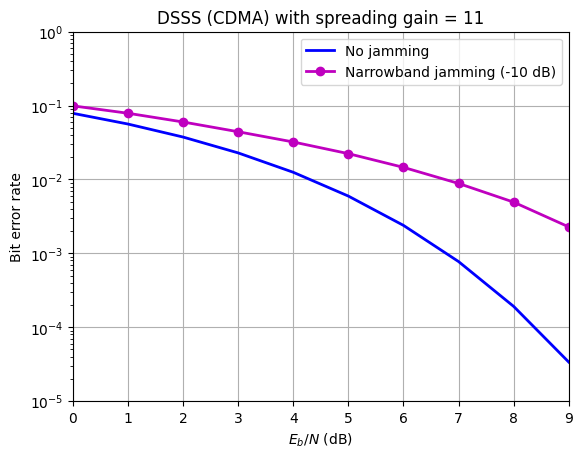

In [6]:
BER = [];  BER_az = [];  Eb2N = []   # Computing BER for given SIR
for i in range(10):
    Eb2N.append(i)  # (Eb/N in dB)
    Eb2N_num = 10 ** (Eb2N[i] / 10)  # Eb/N in numeral
    Var_n = Lc / (2 * Eb2N_num)  # 1/SNR is the noise variance
    signois = np.sqrt(Var_n)  # standard deviation
    awgnois = signois * noiseq  # AWGN
    # Add noise to signals at the channel output
    y_out = x_in + awgnois.flatten() + jammer
    Y_out = np.reshape(y_out, (Ldata, Lc), order='C')
    del y_out, awgnois
    # Despread first
    z_out = np.matmul(Y_out,pcode)
    # Decision based on the sign of the samples
    dec1 = np.sign(np.real(z_out)) + 1j * np.sign(np.imag(z_out))
    # Now compare against the original data to compute BER
    BER.append(np.sum([np.real(data_sym) != np.real(dec1), \
                       np.imag(data_sym) != np.imag(dec1)]) / (2 * Ldata))
    BER_az.append(0.5 * erfc(np.sqrt(Eb2N_num)))  # analytical BER
BER = np.array(BER)
BER[BER==0] = np.nan # replace 0 in BER with 'nan' to mask 0 in logscale plot
fig3 = plt.figure(); fig3.subplots_adjust(hspace=0.5,wspace=0.4)
figber=plt.semilogy(Eb2N,BER_az,'b-',Eb2N,BER,'m-o',linewidth=2)
plt.axis([0, 9, 0.99e-5, 1.])
plt.legend(['No jamming','Narrowband jamming (-10 dB)'])
plt.xlabel(r'$E_b/N$ (dB)'); plt.ylabel('Bit error rate')
plt.title('DSSS (CDMA) with spreading gain = 11'); plt.grid()
plt.show()

<img src="images/Fig10_23.png" width="600" />

<center><b>Figure 10.23</b> Power spectral densities of DSSS signal using Barker code of length 11 for spreading: (a) without narrowband jamming; (b) withnarrowband jamming at SIR=10 dB. </center>

<img src="images/Fig10_24.png" width="600" />

<center><b>Figure 10.24</b> Bit error probabilities of DSSS with QPSK modulation under narrowband jamming. </center>

# 10.9.3 Computer Exercise 10.3: Multiuser DS-CDMA System
<span style="color:red"> <b>*Note: Note: Refer to description from textbook Section 10.9*</b></span>

In [8]:
# This cell generates a table of 4 Gold sequence with length 31 each.
GPN=np.array([[1, 1, 1, -1],
              [-1, 1, -1, 1],
              [-1, -1, 1, 1],
              [1, 1, -1, -1],
              [-1, -1, -1, -1],
              [1, 1, 1, 1],
              [1, 1, -1, -1],
              [-1, -1, -1, 1],
              [-1, 1, -1, -1],
              [1, -1, -1, 1],
              [-1, -1, 1, 1],
              [1, 1, -1, 1],
              [1, -1, -1, -1],
              [-1, 1, 1, 1],
              [1, -1, 1, 1],
              [-1, 1, 1, -1],
              [-1, -1, 1, -1],
              [-1, 1, 1, -1],
              [1, 1, 1, -1],
              [1, -1, 1, 1],
              [1, -1, 1, -1],
              [1, 1, -1, -1],
              [1, 1, 1, 1],
              [1, 1, -1, -1],
              [-1, -1, -1, -1],
              [1, 1, -1, 1],
              [1, -1, -1, -1],
              [-1, 1, -1, 1],
              [1, 1, -1, -1],
              [1, 1, 1, 1],
              [1, 1, 1, 1]])

In [9]:
# This cell tests multiuser DS-CDMA signaling using coherent QPSK for 4 users
Ldata = 200000  # data length in simulation; Must be divisible by 8
Lc = 31  # spreading factor vs data rate
# User number = 4; Generate QPSK modulation symbols
data_sym = (2 * np.round(np.random.rand(Ldata, 4)) - 1) + \
            1j * (2 * np.round(np.random.rand(Ldata, 4)) - 1)

# Select 4 spreading codes (Gold Codes of Length 11)
pcode = GPN
# Spreading codes are now in matrix pcode of 31x4
PowerMat = np.diag(np.sqrt([1, 1, 1, 1]))
pcodew = np.dot(pcode, PowerMat)
# Now spread
x_in =np.kron(data_sym[:,0], pcodew[:,0])+ np.kron(data_sym[:,1], pcodew[:,1])+\
      np.kron(data_sym[:,2], pcodew[:,2])+ np.kron(data_sym[:,3], pcodew[:,3])
# Signal power of the channel input is 2*Lc
# Generate noise (AWGN)
noiseq = np.random.randn(Ldata * Lc)+1j * np.random.randn(Ldata * Lc) # Power=2
number_of_iterations = 12

BER1 = np.zeros((number_of_iterations))
BER2 = np.zeros((number_of_iterations))
BER3 = np.zeros((number_of_iterations))
BER4 = np.zeros((number_of_iterations))
BER_az = np.zeros((number_of_iterations))
Eb2N = []
for i in range(number_of_iterations):
    Eb2N.append(i)  # (Eb/N in dB)
    Eb2N_num = 10 ** (Eb2N[i] / 10)  # Eb/N in numeral
    Var_n = Lc / (2 * Eb2N_num)  # 1/SNR is the noise variance
    signois = np.sqrt(Var_n)  # standard deviation
    awgnois = signois * noiseq  # AWGN

    # Add noise to signals at the channel output
    y_out = x_in + awgnois
    Y_out = np.reshape(y_out, (Ldata, Lc))
    del y_out, awgnois
    z_out = np.dot(Y_out, pcode)    # Despread first
    # Decision based on the sign of the samples
    dec = np.sign(np.real(z_out)) + 1j * np.sign(np.imag(z_out))
    # Now compare against the original data to compute BER
    BER1[i] = np.sum([np.real(data_sym[:, 0]) != np.real(dec[:, 0]),
                    np.imag(data_sym[:, 0]) != np.imag(dec[:, 0])]) / (2 * Ldata)
    BER2[i] = np.sum([np.real(data_sym[:, 1]) != np.real(dec[:, 1]),
                    np.imag(data_sym[:, 1]) != np.imag(dec[:, 1])]) / (2 * Ldata)
    BER3[i] = np.sum([np.real(data_sym[:, 2]) != np.real(dec[:, 2]),
                    np.imag(data_sym[:, 2]) != np.imag(dec[:, 2])]) / (2 * Ldata)
    BER4[i] = np.sum([np.real(data_sym[:, 3]) != np.real(dec[:, 3]),
                    np.imag(data_sym[:, 3]) != np.imag(dec[:, 3])]) / (2 * Ldata)
    BER_az[i] = 0.5 * erfc(np.sqrt(Eb2N_num)) # analytical
# Replace 0 in BER with 'nan'  when plotting in logscale
BER1[BER1==0] = np.nan; BER2[BER2==0] = np.nan
BER3[BER3==0] = np.nan; BER4[BER4==0] = np.nan

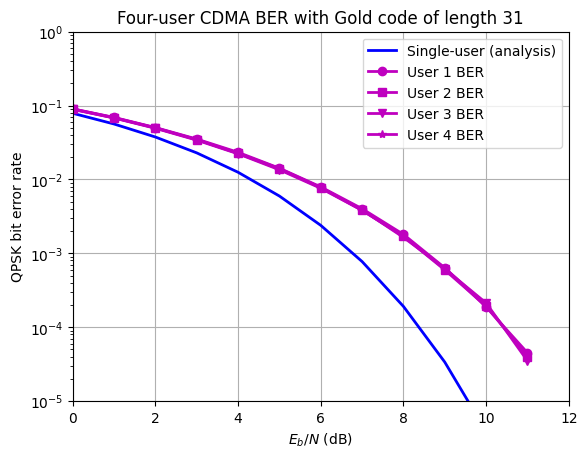

In [10]:
fig1 = plt.figure()
fig1.subplots_adjust(hspace=0.5,wspace=0.4)
figber=plt.semilogy(Eb2N,BER_az,'b-', Eb2N,BER1,'m-o', Eb2N,BER2,'m-s',
                    Eb2N,BER3,'m-v', Eb2N,BER4,'m-*', linewidth=2)
plt.legend(['Single-user (analysis)','User 1 BER','User 2 BER', 'User 3 BER','User 4 BER'])
plt.axis([0, 12, 0.99e-5, 1]); plt.grid()
plt.xlabel(r'$E_b/N$ (dB)'); plt.ylabel('QPSK bit error rate')
plt.title('Four-user CDMA BER with Gold code of length 31')
plt.show()

<img src="images/Fig10_25.png" width="600" />

<center><b>Figure 10.25</b> Performance of DS-CDMA conventional single-user detection without the near-far effect. </center>

# 10.9.4 Computer Exercise 10.4: Multiuser CDMA Detection in Near-Far Environment
<span style="color:red"> <b>*Note: Refer to description from textbook Section 10.9*</b></span>

In [11]:
'''This cell provides simulation for multiuser CDMA system with near-far effect
due to user Tx power differences/variations.'''
# Linear Decorrelator receivers are applied to mitigate the near-far effect
import numpy as np
from scipy.linalg import pinv
from scipy.special import erfc
Ldata = 100000  # data length in simulation; Must be divisible by 8
Lc = 31  # spreading factor vs data rate
# Generate QPSK modulation symbols
data_sym = (2 * np.round(np.random.rand(Ldata, 4)) - 1) + \
           1j * (2 * np.round(np.random.rand(Ldata, 4)) - 1)

pcode = GPN   # Select 4 spreading codes (Gold Codes of Length 11)
# Spreading codes are now in matrix pcode of 31x4
PowerMat = np.diag(np.sqrt([10, 1, 5, 1]))
pcodew = np.matmul(pcode, PowerMat); Rcor = np.matmul(pcodew.T, pcodew)
Rinv = pinv(Rcor)
# Now spread the signals
x_in = np.kron(data_sym[:,0],pcodew[:,0])+np.kron(data_sym[:,1],pcodew[:,1])+\
       np.kron(data_sym[:, 2], pcodew[:, 2])+np.kron(data_sym[:,3],pcodew[:,3])
# Since signal power of the channel input is 2*Lc, generate noise (AWGN)
noiseq = np.random.normal(0, 1, (Ldata * Lc)) + 1j * \
         np.random.normal(0, 1, (Ldata * Lc))  # Power is 2
number_of_iterations = 13
BERb2 = np.zeros((number_of_iterations))
BERa2 = np.zeros((number_of_iterations))
BERb4 = np.zeros((number_of_iterations))
BERa4 = np.zeros((number_of_iterations))
BER_az = np.zeros((number_of_iterations))
Eb2N = []
for i in range(number_of_iterations):
    Eb2N.append(i)  # (Eb/N in dB)
    Eb2N_num = 10**(Eb2N[i]/10)  # Eb/N in numeral
    Var_n = Lc / (2 * Eb2N_num)  # 1/SNR is the noise variance
    signois = np.sqrt(Var_n)  # standard deviation
    awgnois = signois * noiseq  # AWGN
    # Add noise to signals at the channel output
    y_out = x_in + awgnois
    Y_out = np.reshape(y_out, (Ldata, Lc))
    del y_out, awgnois
    # Despread first and apply decorrelator Rinv
    z_out = np.matmul(Y_out, pcode)
    del Y_out
    z_dcr = np.matmul(z_out, Rinv)  # decorrelator output
    # Decision based on the sign of the single receivers
    dec1 = np.sign(np.real(z_out)) + 1j * np.sign(np.imag(z_out))
    dec2 = np.sign(np.real(z_dcr)) + 1j * np.sign(np.imag(z_dcr))
    # Now compare against the original data to compute BER of user 2
    # and user 4 (weaker ones).
    BERa2[i] =np.sum([np.real(data_sym[:,1]) !=np.real(dec1[:, 1]),
                       np.imag(data_sym[:,1]) !=np.imag(dec1[:, 1])])/(2*Ldata)
    BERa4[i] =np.sum([np.real(data_sym[:,3]) !=np.real(dec1[:, 3]),
                       np.imag(data_sym[:,3]) !=np.imag(dec1[:, 3])])/(2*Ldata)
    BERb2[i] =np.sum([np.real(data_sym[:,1]) !=np.real(dec2[:, 1]),
                       np.imag(data_sym[:,1]) !=np.imag(dec2[:, 1])])/(2*Ldata)
    BERb4[i] =np.sum([np.real(data_sym[:,3]) !=np.real(dec2[:, 3]),
                       np.imag(data_sym[:,3]) !=np.imag(dec2[:, 3])])/(2*Ldata)
    BER_az[i]=0.5 * erfc(np.sqrt(Eb2N_num)) # analytical

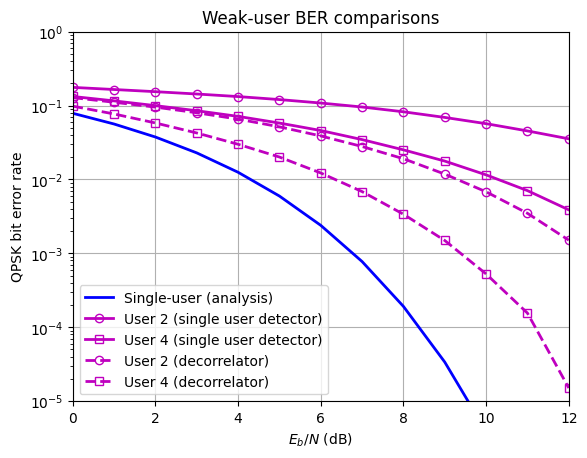

In [12]:
fig1 = plt.figure()
fig1.subplots_adjust(hspace=0.5,wspace=0.4)
figber=plt.semilogy(Eb2N,BER_az,'b-', Eb2N,BERa2,'m-o',Eb2N,BERa4,'m-s',
                    Eb2N,BERb2,'m--o',Eb2N,BERb4,'m--s',mfc='none',linewidth=2)
plt.legend(['Single-user (analysis)','User 2 (single user detector)',
            'User 4 (single user detector)','User 2 (decorrelator)',
            'User 4 (decorrelator)'])
plt.axis([0, 12, 0.99e-5, 1.])
plt.xlabel(r'$E_b/N$ (dB)');plt.ylabel(r'QPSK bit error rate')
plt.title('Weak-user BER comparisons');plt.grid()
plt.show()

<img src="images/Fig10_26.png" width="600" />

<center><b>Figure 10.26</b> Performance of decorrelator MUD in comparison with the conventional single-user receiver. </center>



In [13]:
'''This cell provides simulation for multiuser CDMA system with near-far effect
due to user Tx power differences/variations.'''
# Decision feedback receivers are applied to mitigate the near-far effect
import numpy as np
from scipy.special import erfc
Ldata = 200000  # data length in simulation; Must be divisible by 8
Lc = 31  # spreading factor vs data rate

# Generate QPSK modulation symbols
np.random.seed(10)
data_sym = (2 * np.round(np.random.rand(Ldata, 4)) - 1) + \
            1j * (2 * np.round(np.random.rand(Ldata, 4)) - 1)

# Select 4 spreading codes (Gold Codes of Length 11)
pcode = GPN  # assuming GPN is defined elsewhere
# Spreading codes are now in matrix pcode of 31x4
PowerMat = np.diag(np.sqrt([10, 1, 5, 1]))
pcodew = np.dot(pcode, PowerMat)
Rcor = np.dot(pcodew.T, pcodew)
# Now spread
x_in = np.kron(data_sym[:, 0], pcodew[:, 0]) + np.kron(data_sym[:, 1], pcodew[:, 1]) + \
       np.kron(data_sym[:, 2], pcodew[:, 2]) + np.kron(data_sym[:, 3], pcodew[:, 3])

# Signal power of the channel input is 2*Lc
# Generate noise (AWGN)
noiseq = np.random.randn(Ldata * Lc) + 1j * np.random.randn(Ldata * Lc)  # Power is 2
number_of_iterations = 13

BER_c2 = np.zeros((number_of_iterations));BER2 = np.zeros((number_of_iterations))
BER_c4 = np.zeros((number_of_iterations));BER4 = np.zeros((number_of_iterations))
BER_az = np.zeros((number_of_iterations));Eb2N = []
for i in range(number_of_iterations):
    Eb2N.append(i)  # (Eb/N in dB)
    Eb2N_num = 10 ** (Eb2N[i] / 10)  # Eb/N in numeral
    Var_n = Lc / (2 * Eb2N_num)  # 1/SNR is the noise variance
    signois = np.sqrt(Var_n)  # standard deviation
    awgnois = signois * noiseq  # generate AWGN
    # Add noise to signals at the channel output
    y_out = x_in + awgnois
    Y_out = np.reshape(y_out, (Ldata, Lc))
    del y_out, awgnois
    # Despread first
    z_out = np.dot(Y_out, pcode)
    del Y_out
    # Decision based on the sign of the single receivers
    dec = np.sign(np.real(z_out)) + 1j * np.sign(np.imag(z_out))
    # Decision based on the sign of the samples
    dec1 = np.sign(np.real(z_out[:, 0])) + 1j * np.sign(np.imag(z_out[:, 0]))
    z_fk1 = z_out - dec1.reshape(-1, 1) * Rcor[0, :]
    dec3 = np.sign(np.real(z_fk1[:, 2])) + 1j * np.sign(np.imag(z_fk1[:, 2]))
    z_fk2 = z_fk1 - dec3.reshape(-1, 1) * Rcor[2, :]
    dec2 = np.sign(np.real(z_fk2[:, 1])) + 1j * np.sign(np.imag(z_fk2[:, 1]))
    z_fk3 = z_fk2 - dec2.reshape(-1, 1) * Rcor[1, :]
    dec4 = np.sign(np.real(z_fk3[:, 3])) + 1j * np.sign(np.imag(z_fk3[:, 3]))
    # Now compare against the original data to compute BER
    BER_c2[i] = np.sum([np.real(data_sym[:, 1]) != np.real(dec[:, 1]),
                        np.imag(data_sym[:, 1]) != np.imag(dec[:,1])])/(2*Ldata)
    BER2[i] = np.sum([np.real(data_sym[:, 1]) != np.real(dec2),
                      np.imag(data_sym[:, 1]) != np.imag(dec2)]) / (2 * Ldata)
    BER_c4[i] = np.sum([np.real(data_sym[:, 3]) != np.real(dec[:, 3]),
                        np.imag(data_sym[:, 3]) != np.imag(dec[:,3])])/(2*Ldata)
    BER4[i] = np.sum([np.real(data_sym[:, 3]) != np.real(dec4),
                      np.imag(data_sym[:, 3]) != np.imag(dec4)]) / (2 * Ldata)
    BER_az[i] = 0.5 * erfc(np.sqrt(Eb2N_num)) # analytical
# Replace 0 in BER with 'nan' so that 0 values can be masked when plotting in logscale
BER_c2[BER_c2==0] = np.nan
BER2[BER2==0] = np.nan
BER_c4[BER_c4==0] = np.nan
BER4[BER4==0] = np.nan
del z_fk1, z_fk2, z_fk3, dec1, dec3, dec2, dec4, x_in, noiseq

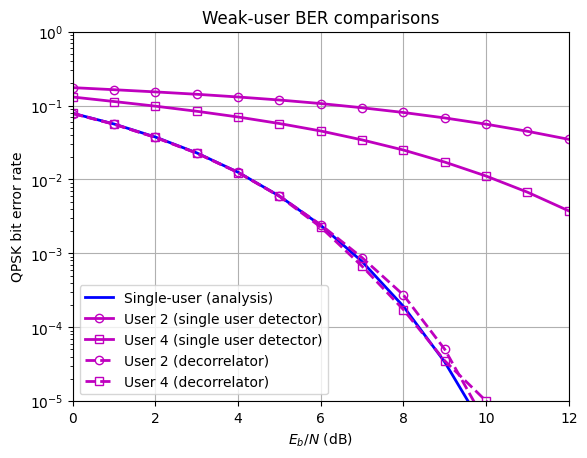

In [15]:
fig2 = plt.figure()
fig2.subplots_adjust(hspace=0.5,wspace=0.4)
figber=plt.semilogy(Eb2N,BER_az,'b-', Eb2N,BER_c2,'m-o',Eb2N,BER_c4,'m-s',
                    Eb2N,BER2,'m--o',Eb2N,BER4,'m--s',mfc='none',linewidth=2)
plt.legend(['Single-user (analysis)','User 2 (single user detector)',
            'User 4 (single user detector)','User 2 (decorrelator)',
            'User 4 (decorrelator)'])
plt.axis([0, 12, 0.99e-5, 1.])
plt.xlabel(r'$E_b/N$ (dB)');plt.ylabel(r'QPSK bit error rate')
plt.title('Weak-user BER comparisons');plt.grid()
plt.show()

<span style="color:red"> <b>*Note: text on p.739-740 skipped*</b></span>

<img src="images/Fig10_27.png" width="600" />

<center><b>Figure 10.27</b> Performance of decision feedback MUD in comparison with the conventional single-user receiver. </center>